In [149]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.datasets import make_blobs
import pandas as pd
import random



class multinomial_regressor():
    def __init__(self,number_of_cluster) :
        self.parameter_list = []
        self.number_of_cluster = number_of_cluster
        self.training_data = []
        self.error_data = []
 
    def sigmoid(self,x):
        return (1/(1+np.exp(-x)))
    
    def initialize_parameters(self):
        '''
        Intializes parameter of n number of logistic regressor randomly
        '''
        # Initializing Coefficients
        for i in range(0,self.number_of_cluster) :
            temp_parameter = {
                "w1" : random.random() * 0.001,
                "w2" : random.random() * 0.001,
                "b" : random.random() * 0.001,
            }
            self.parameter_list.append(temp_parameter)

    def get_parameter_list(self):
        return self.parameter_list

    def calc_output_array(self,x,parameter):
        '''
        Outputs the function value based on X a numpy array
        return a output numpy array
        '''
        w1,w2,b = parameter["w1"], parameter["w2"], parameter["b"] 
        return self.sigmoid(w1 * x[:,0] + w2 * x[:,1] + b)


    def predict_probability(self,X):
        probability = []
        for parameter in self.parameter_list:
            probability.append(self.calc_output_array(X,parameter))
        probability_array = np.dstack(probability)
        return probability_array
    

    def predict(self,X):
        probability_array = self.predict_probability(X)
        return np.argmax(probability_array, axis=2).flatten()
    
    def prediction_for_animation(self,X,current_parameter_list):
        probability = []
        for parameter in current_parameter_list:
            probability.append(self.calc_output_array(X,parameter))
        probability_array = np.dstack(probability)
        return np.argmax(probability_array, axis=2).flatten()

    def calc_output(self,x,regressor_index):
        '''
        Outputs the function value based on x
        '''
        w1,w2,b = self.parameter_list[regressor_index]["w1"],self.parameter_list[regressor_index]["w2"],self.parameter_list[regressor_index]["b"] 
        return self.sigmoid(w1 * x[0] + w2 * x[1] + b)
        
    
    def binary_cross_entropy_loss (self,Y_hat, Y):
        return -(Y * np.log(Y_hat) + (1 - Y)* np.log(1 - Y_hat))
    
    def categorical_cross_entropy_loss (self,Y_hat_probability, Y_encoded):
        loss = self.binary_cross_entropy_loss(Y_hat_probability.flatten(),Y_encoded.flatten())
        loss = loss.flatten()
        return loss
        
    def gradient_descent(self,X,Y,regressor_index):
        '''
        Given data X and Y along with the current parameters,
        calculates and returns the gradient of each parameters as a dictionary
        
        '''
        grad_w1,grad_w2,grad_b = 0.,0.,0.

        for i in range(0,X.shape[0]):
            y_hat = self.calc_output(X[i],regressor_index) 
            error = y_hat - Y[i]
            grad_w1 += error * X[i][0]
            grad_w2 += error * X[i][1]
            grad_b += error 
        
        grad_w1 /= X.shape[0]
        grad_w2 /= X.shape[0]
        grad_b /= X.shape[0]

        grad = {
            "grad_w1" : grad_w1 ,
            "grad_w2" : grad_w2 ,
            "grad_b" : grad_b
        }

        return grad
    
    def encode_data(self,Y):
        encoded_data = []
        for y in Y:
            encoded = np.zeros((1,self.number_of_cluster))
            encoded[0][y] = 1
            encoded_data.append(encoded)
        return np.asarray(encoded_data)
            
    def update_weights(self,grad,learning_rate,regressor_index):
        '''
        Updates the parameters and returns as a dictionary
        '''


        w1,w2,b = self.parameter_list[regressor_index]["w1"],self.parameter_list[regressor_index]["w2"],self.parameter_list[regressor_index]["b"]
        w1 -= learning_rate * grad["grad_w1"]
        w2 -= learning_rate * grad["grad_w2"]
        b -= learning_rate * grad["grad_b"]

        updated_parameters = {
            "w1" : w1,
            "w2" : w2,
            "b" : b
        }
        
        self.parameter_list[regressor_index] = updated_parameters
     
    
    def train(self,X,Y,learning_rate = 0.01,epochs = 200) :
        self.initialize_parameters()
        dataset_length = X.shape[0]
        Y_encoded = self.encode_data(Y)

        for i in range(0,epochs+1):
            for regressor_index in range(0,self.number_of_cluster) :
                y = Y_encoded[:,:,regressor_index].flatten()
                grad = self.gradient_descent(X,y,regressor_index)
                self.update_weights(grad,learning_rate,regressor_index)
               
            Y_hat_probability = self.predict_probability(X) 
            cost  =  self.categorical_cross_entropy_loss(Y_hat_probability , Y_encoded)
            # Display current epoch and error
            cost_value = np.sum(cost)/dataset_length
            if i%10 == 0 :
                print(f'Epoch {i}, Error: {cost_value}')
            self.error_data.append(cost_value)
            self.training_data.append(self.parameter_list.copy())


    def plot_epochs(self):
        '''
        Plots epochs vs cost graph
        '''
        plt.figure(figsize= (10,5)) 
        plt.plot(self.error_data)
        plt.xlabel("Epochs")
        plt.ylabel(" Categorical Cross Entropy Loss")
        plt.title("Categorical Cross Entropy Loss vs Epoch ")
        plt.show()

    def plot_decision_boundary(self,X, Y):
        xmin, xmax = np.min(X[:,0]), np.max(X[:,0])
        ymin, ymax = np.min(X[:,1]), np.max(X[:,1])
        xx, yy = np.meshgrid(np.arange(xmin, xmax, 0.02),
                            np.arange(ymin, ymax, 0.02))
        
        # Predict the function value for the whole grid
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Plot the contour and training examples
        plt.figure(figsize=(20, 10))
        plt.contourf(xx, yy, Z, alpha=0.8)
        plt.scatter(X[:, 0], X[:, 1], c= Y, edgecolors='k', s=20)
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.title('Decision Boundary of Multinomial Logistic Regression')
        plt.show()

    def show_training_animation(self,X,Y,path):
        '''
        Displays animation of the algorithm learning to fit the data using gradient descent.
        '''
        fig, ax = plt.subplots()
        xmin, xmax = np.min(X[:,0]), np.max(X[:,0])
        ymin, ymax = np.min(X[:,1]), np.max(X[:,1])
        xx, yy = np.meshgrid(np.arange(xmin, xmax, 0.02),np.arange(ymin, ymax, 0.02))

        def update(i) :
            ax.clear()
            current_parameters = self.training_data[i]
            Z = self.prediction_for_animation(np.c_[xx.ravel(), yy.ravel()],current_parameters)
            Z = Z.reshape(xx.shape)
            ax.set_title('Decision Boundary of Multinomial Logistic Regression : Epoch ' +  str(i))
            # Plot the contour and training examples
            ax.contourf(xx, yy, Z, alpha=0.8)
            ax.scatter(X[:, 0], X[:, 1], c= Y, edgecolors='k', s=20)
            ax.set_xlabel('x1')
            ax.set_ylabel('x2')
            
        ani = FuncAnimation(fig, update, frames=len(self.training_data), interval=100)
        ani.save(filename= path , writer="pillow")
        plt.show()


In [150]:
def data_generator(cluster = 3):
  '''
  This function generates data X and Y of given cluster numbers
  X represents a point in 2D coordinates and Y is label which will be either 1 or 0 in case of 2 clusters
  '''
  X, Y = make_blobs(n_samples=500, centers= cluster, n_features= 2)
  return X,Y

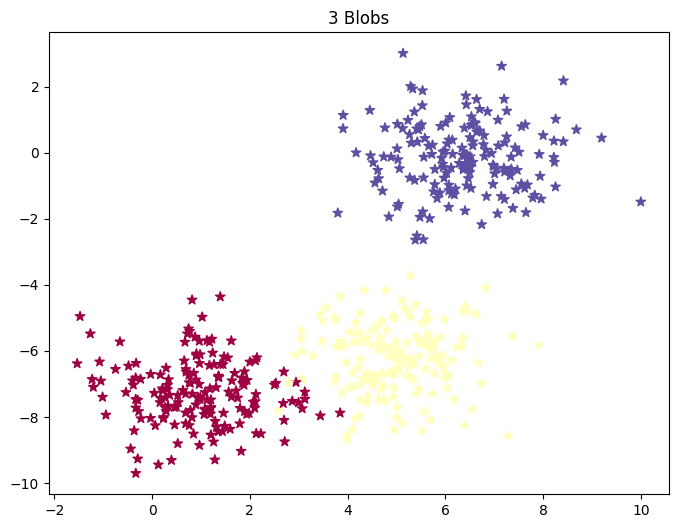

In [151]:
number_of_cluster = 3
X,Y = data_generator(cluster= number_of_cluster)
plt.figure(figsize=(8, 6))
plt.title(str(number_of_cluster) +" Blobs")
plt.scatter(X[:, 0], X[:, 1], marker="*", c= Y, s=50, cmap ="Spectral") # Here Y is passed in color argument to show different colors for different classes

In [152]:
multi_regressor = multinomial_regressor(number_of_cluster)

In [153]:
multi_regressor.train(X,Y,learning_rate = 0.01 , epochs = 200)

Epoch 0, Error: 2.0012022911629335
Epoch 10, Error: 1.5666414691786394
Epoch 20, Error: 1.3755059648368646
Epoch 30, Error: 1.2616047268195034
Epoch 40, Error: 1.1847738992140704
Epoch 50, Error: 1.1290585914587254
Epoch 60, Error: 1.0865474555348007
Epoch 70, Error: 1.0528468469113732
Epoch 80, Error: 1.0253253639457134
Epoch 90, Error: 1.0023131550614914
Epoch 100, Error: 0.9826997532791504
Epoch 110, Error: 0.9657174769224882
Epoch 120, Error: 0.9508180431090011
Epoch 130, Error: 0.9375988890918201
Epoch 140, Error: 0.9257573625472287
Epoch 150, Error: 0.9150612243669389
Epoch 160, Error: 0.9053290651311003
Epoch 170, Error: 0.8964169489281365
Epoch 180, Error: 0.8882090850963665
Epoch 190, Error: 0.880611174027987
Epoch 200, Error: 0.8735455700632058


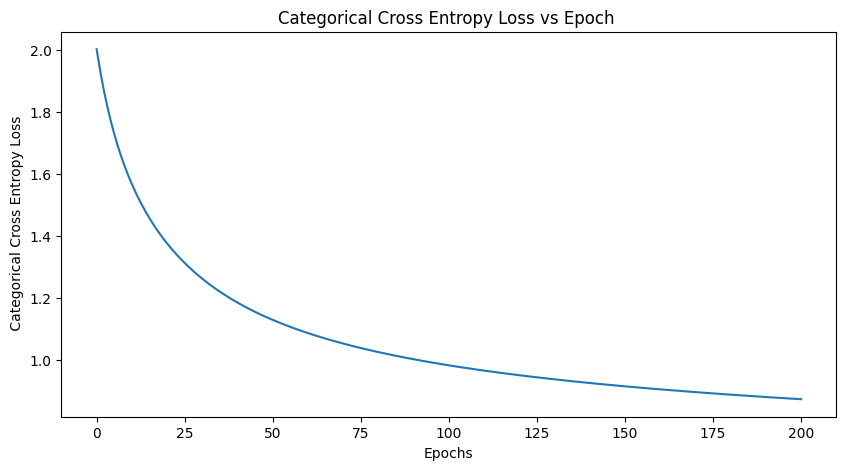

In [154]:
multi_regressor.plot_epochs()

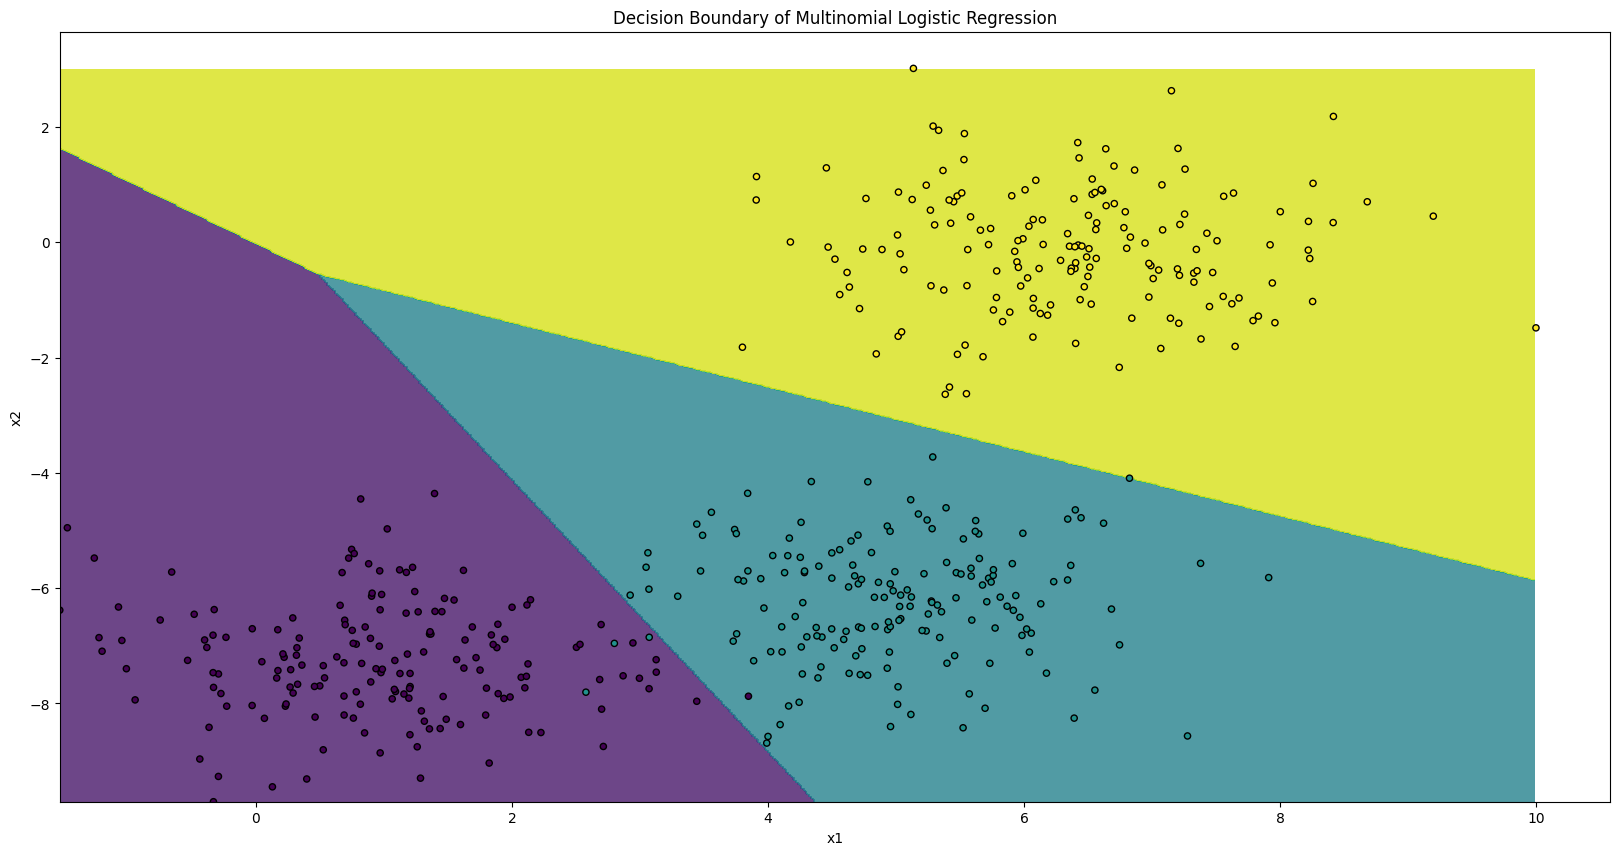

In [155]:
multi_regressor.plot_decision_boundary(X,Y)

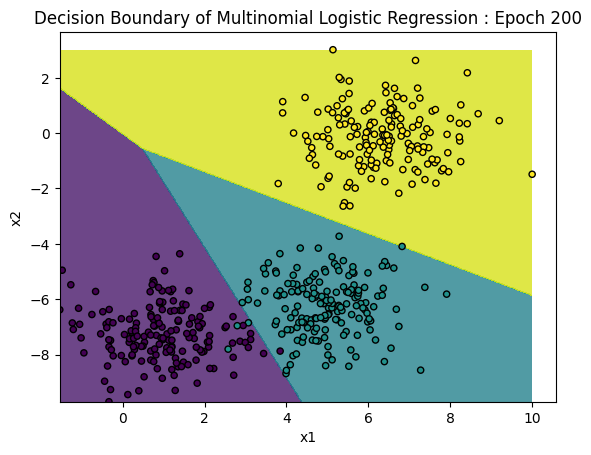

In [156]:
multi_regressor.show_training_animation(X,Y,"multinomial_regression.gif")

In [157]:
# def show_training_animation(X,Y,multi_regressor):
#     '''
#     Displays animation of the algorithm learning to fit the data using gradient descent.
#     '''
#     fig, ax = plt.subplots()
#     xmin, xmax = np.min(X[:,0]), np.max(X[:,0])
#     ymin, ymax = np.min(X[:,1]), np.max(X[:,1])
#     xx, yy = np.meshgrid(np.arange(xmin, xmax, 0.02),np.arange(ymin, ymax, 0.02))

#     def update(i) :
#         ax.clear()
#         current_parameters = multi_regressor.training_data[i]
#         Z = multi_regressor.prediction_for_animation(np.c_[xx.ravel(), yy.ravel()],current_parameters)
#         Z = Z.reshape(xx.shape)
#         ax.set_title('Decision Boundary of Multinomial Logistic Regression : Epoch ' +  str(i))
#         # Plot the contour and training examples
#         ax.contourf(xx, yy, Z, alpha=0.8)
#         ax.scatter(X[:, 0], X[:, 1], c= Y, edgecolors='k', s=20)
#         ax.set_xlabel('x1')
#         ax.set_ylabel('x2')
        
        
#     ani = FuncAnimation(fig, update, frames=len(multi_regressor.training_data), interval=100)
#     ani.save(filename="logistic_regression.gif", writer="pillow")
#     plt.show()